In [ ]:
## and ou may ask yourself, "Well, how did I get here?"...

## TF WordEmbedding CBOW skip-gram Word2Vec 121220 and 070223
# word embedding, = vector-spaces where semantic-relationships between words modeled as distance between vectors or words
# CBOW, (Word2Vec probability-model #1) (minimize avg neg log-likelihood)(use context to predict current word)
# Skip-gram, (Word2Vec probability-model #2) (avg,neg,log) (use current word to predict neighbors (it's context))
# Word2vec (avg: gives mean error, neg: optimizer decreases error, log: products transformed to summation)
# Use tensorflow_hub and embed 2-3 words. Look at the resulting vectors.


In [ ]:
# CBOW and Skip-gram are mirror-images.
# CBOW =  predict single word from fixed window size
# Skip-gram = predicts several context words from single input. Input = center word. Predictions = context words.
# Architecture: i)randomly-initialize word-embedding for word, ii)projection matrix NxD (num context-words X embedding-dim)
# ..generated each iteration, no hidden-layer, iii) vectors averaged together then fed into activation-function to pred
# ..index-probs in vector of dim V (size of vocab)


In [ ]:
# 2-types of NLP: i) bag-of-words[Dense] (process sets or N-grams without order,) ii) sequence[Transformer] (with order)
# ** ratio between num-samples in train-data & mean num-of-words per sample determines whether to use i) or ii)
# ** num_samples / mean_sample_length: if >1500 use Bag-of-bigrams, if <1500 use Sequence model
# ** example: 1000-word docs / 100,000 docs = ratio is 100, go with Bag-of-bigrams
# i) statistical language model to analyze text used for nlp based on word counts
# ii) sequence-to-sequence = encoder processes source sequence, decoder predicts future tokens in target sequence of past
# neural-attention: creates context-aware word-reps = Transormer-architecture
# Transormer = TransformerEndcoder & TransformerDecoder


In [ ]:
## START CBOW

# CBOW = continuous-bag-of-words which is a part of Word2Vec
# cbow model-architecture predicts current target-word based on source context-words
# we decide the vector-dims / embedding-dims, ex. embedding-dim = 2, then 'hello' = [0.213, 0.4543]
# cbow has input (1-hot), hidden (w + b), and output layers, then we pred via softmax
# workflow: prep data, create train-data, create cbow-model, train cbow-model, eval cbow-model


In [ ]:
import gensim.downloader as api

info = api.info()  # show info about available models/datasets
model = api.load("glove-twitter-25")  # download the model and return as object ready for use
model.most_similar("cat")


[('dog', 0.9590820074081421),
 ('monkey', 0.9203579425811768),
 ('bear', 0.9143137335777283),
 ('pet', 0.9108031392097473),
 ('girl', 0.8880630731582642),
 ('horse', 0.8872725963592529),
 ('kitty', 0.8870542049407959),
 ('puppy', 0.8867696523666382),
 ('hot', 0.886525571346283),
 ('lady', 0.8845519423484802)]

In [ ]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

model=Word2Vec(sentences=common_texts, vector_size=100, window=5, min_count=1, workers=4)
model.save('word2vec.model')


In [ ]:
model = Word2Vec.load('word2vec.model')
model.train([['hello', 'world']], total_examples=1, epochs=1)


(0, 2)

In [ ]:
vector=model.wv['computer']
sims=model.wv.most_similar('computer', topn=10)


In [ ]:
from gensim.models import KeyedVectors
word_vectors = model.wv
word_vectors.save('word2vec.wordvectors')

wv=KeyedVectors.load('word2vec.wordvectors', mmap='r')


In [ ]:
from gensim.test.utils import datapath
wv_from_text = KeyedVectors.load_word2vec_format(datapath('word2vec_pre_kv_c'), binary=False)
wv_from_bin = KeyedVectors.load_word2vec_format(datapath('euclidean_vectors.bin'), binary=True)


In [ ]:
# end CBOW


In [ ]:
# Start Skip-Gram


In [ ]:
import numpy as np
import pandas as pd
from nltk.tokenize.regexp import RegexpTokenizer
from nltk.corpus import stopwords
from gensim.models import Word2Vec, KeyedVectors
from scipy.spatial.distance import cosine


In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', context='talk')


In [ ]:
# intentional ambiguity to try and confuse the model

text = ['Run jump run jump up and down outside.',
        'Old MacDonald had a jumper.',
        'The car is parked in the garage.',
        'The garage was built to house the cars.'
        'The house is attached to the garage which is good since its close by.',
        'The attached garage is good because its a short walk to the house.',
        'A short walk is enjoyable after dinner on the patio',
        'A patio is an enjoyable place for dinner.',
        'Dinner is after lunch.',
        'Lunch is before.',
        'Before lunch you can sit on the patio.',
        'The lion wanted breakfast and wandered near the patio.',
        'The wandering meanandering cheetah was near the lion.',
        'Old MacDonald ate a bag of cheetohs.',
        'Cheetohs are orange.',
        'Eating an orange on the patio while looking at the lion is fun said Old MacDonald.']


In [ ]:
def preprocess_text(document):
    tokenizer = RegexpTokenizer(r"[A-Za-z]{2,}")
    tokens = tokenizer.tokenize(document.lower())
    key_tokens = [token for token in tokens if token not in stopwords.words('english')]
    return key_tokens

corpus = []
for document in text:
    corpus.append(preprocess_text(document))
corpus


[['run', 'jump', 'run', 'jump', 'outside'],
 ['old', 'macdonald', 'jumper'],
 ['car', 'parked', 'garage'],
 ['garage',
  'built',
  'house',
  'cars',
  'house',
  'attached',
  'garage',
  'good',
  'since',
  'close'],
 ['attached', 'garage', 'good', 'short', 'walk', 'house'],
 ['short', 'walk', 'enjoyable', 'dinner', 'patio'],
 ['patio', 'enjoyable', 'place', 'dinner'],
 ['dinner', 'lunch'],
 ['lunch'],
 ['lunch', 'sit', 'patio'],
 ['lion', 'wanted', 'breakfast', 'wandered', 'near', 'patio'],
 ['wandering', 'meanandering', 'cheetah', 'near', 'lion'],
 ['old', 'macdonald', 'ate', 'bag', 'cheetohs'],
 ['cheetohs', 'orange'],
 ['eating',
  'orange',
  'patio',
  'looking',
  'lion',
  'fun',
  'said',
  'old',
  'macdonald']]

In [ ]:
dimension = 2
window = 2
word2vec = Word2Vec(corpus, min_count=1, vector_size=dimension, window=window, sg=1)
word2vec.wv.get_vector('patio')


array([-0.02654754,  0.0114735 ], dtype=float32)

In [ ]:
n=3
word2vec.wv.most_similar(positive=['patio'], topn=n)


[('looking', 0.9974758625030518),
 ('parked', 0.9954480528831482),
 ('cheetah', 0.9781259298324585)]

In [ ]:
embedding = pd.DataFrame(columns=['d0', 'd1'])
for token in word2vec.wv.index_to_key:
    embedding.loc[token] = word2vec.wv.get_vector(token)
embedding


,d0,d1
patio,-0.026548,0.011474
garage,0.254888,0.450171
dinner,-0.465057,-0.355795
lion,0.322857,0.448189
old,-0.250914,-0.188650
macdonald,0.369047,-0.076846
house,-0.226831,0.327703
lunch,-0.243008,-0.090801
jump,0.143574,0.049691
attached,-0.414787,-0.472955


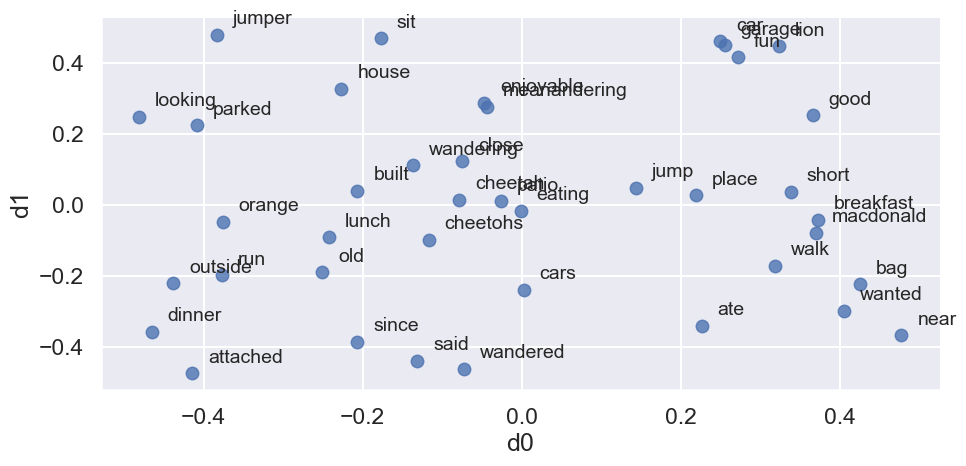

In [ ]:
sns.lmplot(data=embedding, x='d0', y='d1', fit_reg=False, aspect=2)
for token, vector in embedding.iterrows():
    plt.gca().text(vector['d0']+.02, vector['d1']+.03, str(token), size=14)
plt.tight_layout()


In [ ]:
# End skip-gram


In [ ]:
# Start tb 2-gram & 3-gram


In [ ]:
def split_Text_To_TWO_gram(string):

    words = string.split()

    TWO_gram_words = [' '.join(words[i: i + 2]) for i in range(0, len(words), 1)]

    return TWO_gram_words

split_Text_To_TWO_gram('this is an example sentence for the 2-gram words')


['this is',
 'is an',
 'an example',
 'example sentence',
 'sentence for',
 'for the',
 'the 2-gram',
 '2-gram words',
 'words']

In [ ]:
def split_Text_To_THREE_gram(string):

    words = string.split()

    THREE_gram_words = [' '.join(words[i: i + 3]) for i in range(0, len(words), 1)]

    return THREE_gram_words

split_Text_To_THREE_gram('this is an example sentence for the 3-gram words')


['this is an',
 'is an example',
 'an example sentence',
 'example sentence for',
 'sentence for the',
 'for the 3-gram',
 'the 3-gram words',
 '3-gram words',
 'words']

In [ ]:
# END 121220 #
# END 070423 #
